# Machine Learning Project of Canadian Cheeses Dataset

<div style="text-align: right"> November 14, 2021 </div>

<div style="text-align: right"> ML Final Project Report by Peng Zhang </div>

## Introduction

This machine learning project will be using a dataset regarding the different types of Canadian cheeses. The pre-processed dataset to be analyzed is provided by UBC Introduction to Machine Learning course. And the original data can be accessed on the <a href="https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b" target="_blank">Government of Canada's Open Government Portal</a> and follows an <a href="https://open.canada.ca/en/open-government-licence-canada" target="_blank">Open Government Licence (Canada)</a>. 

### Question of Interest

Dairy products have become controversial the recent years as more and more people are concerned about their health effects and environmental impacts. Specific to the cheese industry, a large number of consumers globally started to eat it on a low-fat diet. 

In this analysis, a dataset containing 1,042 Canadian cheeses will be studied by using Machine Learning methods. The task is to find out an appropriate algorithm that can be deployed to answer a **classification question** of whether the given cheese should be identified as a lower fat or higher fat product. Based on our interest, the **lower fat** would be the **positive label**.

## Exploratory Data Analysis

In [1]:
# Import libraries needed for this lab

import altair as alt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import SVC, SVR

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Firstly, read the dataset into Jupyter notebook.

In [2]:
cheess_df = pd.read_csv("data/cheese_data.csv")

cheess_df.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


In order to avoid violating the golden rule, before doing anything with the data, it will be splited as training and test datasets.

In [3]:
train_df, test_df = train_test_split(cheess_df, test_size=0.2, random_state=555)

Look at the column dtypes and basic column information for training dataset using `.info()` and `.describe()`.

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 244 to 410
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              833 non-null    int64  
 1   ManufacturerProvCode  833 non-null    object 
 2   ManufacturingTypeEn   833 non-null    object 
 3   MoisturePercent       821 non-null    float64
 4   FlavourEn             644 non-null    object 
 5   CharacteristicsEn     516 non-null    object 
 6   Organic               833 non-null    int64  
 7   CategoryTypeEn        817 non-null    object 
 8   MilkTypeEn            832 non-null    object 
 9   MilkTreatmentTypeEn   780 non-null    object 
 10  RindTypeEn            583 non-null    object 
 11  CheeseName            833 non-null    object 
 12  FatLevel              833 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 91.1+ KB


In [5]:
train_df.describe(include='all')

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
count,833.000000,833,833,821.000000,644,516,833.000000,817,832,780,583,833,833
unique,NaN,10,3,NaN,521,438,NaN,6,8,3,4,831,2
top,NaN,QC,Industrial,NaN,Mild,Creamy,NaN,Firm Cheese,Cow,Pasteurized,No Rind,Fromage en grain,lower fat
freq,NaN,635,363,NaN,50,15,NaN,274,593,638,322,2,539
mean,1560.026411,NaN,NaN,47.112667,NaN,NaN,0.097239,NaN,NaN,NaN,NaN,NaN,NaN
std,448.473417,NaN,NaN,9.634495,NaN,NaN,0.296461,NaN,NaN,NaN,NaN,NaN,NaN
min,228.000000,NaN,NaN,12.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1284.000000,NaN,NaN,40.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1555.000000,NaN,NaN,46.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,1901.000000,NaN,NaN,52.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


From the above glance at the dataset, 12 columns provide various information, such as the identification, the manufacturing, the type of milk, the cheese category, the milk treatment, the moisture percentage, the fat level, etc. Most of the columns are categorical features. 

According to the defined predictive question, the column of `FatLevel` will be establised as the **target feature**.

To start an exploratory data analysis (EDA), two **irrelevant columns**, `CheeseId`,`RindTypeEn` will be **droped** and all other columns will be grouped into different categories for Machine Learning purposes.

In [6]:
# Drop irrelevant columns
train_df = train_df.drop(columns=['CheeseId','RindTypeEn'])

In [7]:
# Group all columns to be analyzed into different categories
numeric_features = ['MoisturePercent']
categorical_features = ['ManufacturerProvCode', 'ManufacturingTypeEn', 'CategoryTypeEn','MilkTypeEn','MilkTreatmentTypeEn']
binary_features = ['Organic']
text_features = ['FlavourEn','CharacteristicsEn','CheeseName']
target_column = 'FatLevel'

In the EDA stage, plotting is an effective and efficient tool to visually explore if there are some types of **patterns or relationships between the target feature and input features**. Three bar charts have been generated as below to visualize the distribution of distinct categories of features (except the text features) as per the fat level.

In [8]:
# Plot the distribution of numeric feature(s) per fat level
plot_1_dist_num = alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(),type='quantitative',title="Moisture percentage (%)"),
    alt.Y('count():Q',title="Number of samples"),
    alt.Color('FatLevel:N',title="Fat level")
).repeat(numeric_features).properties(title="Figure 1 Distribution of numeric feature(s) per fat level")

plot_1_dist_num

alt.RepeatChart(...)

In [9]:
# Plot the distribution of categorical features per fat level
# Set y-axis for categorical features to make more readable
plot_2_dist_cal = alt.Chart(train_df).mark_bar().encode(
    alt.X('count():Q',title="Number of samples"),
    alt.Y(alt.repeat(),type='nominal'),
    alt.Color('FatLevel:N',title="Fat level")
).repeat(categorical_features).properties(title="Figure 2 Distribution of categorical features per fat level")

plot_2_dist_cal

alt.RepeatChart(...)

In [10]:
# Plot the distribution of binary feature(s) per fat level
plot_3_dist_binary = alt.Chart(train_df).mark_bar().encode(
    alt.X('count():Q',title="Number of samples"),
    alt.Y(alt.repeat(),type='nominal'),
    alt.Color('FatLevel:N',title="Fat level")
).repeat(binary_features).properties(title="Figure 3 Distribution of binary feature(s) per fat level")

plot_3_dist_binary

alt.RepeatChart(...)

From Figures 1 to 3, it seems that the cheese with more moisture contained is more likely to have lower fat. So far there is no clear pattern to indicate the other features' relationship with the target feature from the predictive perspectives. So the assumption is the feature of `MoisturePercent` possibly has more weight to predict whether the cheese has higher fat or lower fat. This could be further examed if an interpretable model is applied in the prediction.

In order to discover if there is a **class imbalance issue** in the dataset, the following visualization will plot the distrubition of samples as per the fat level.

In [11]:
plot_4_dist_target = alt.Chart(train_df).mark_bar().encode(
    alt.X('count():Q',title="Number of samples"),
    alt.Y(target_column,type='nominal'),
    alt.Color('FatLevel:N',title="Fat level")
).properties(title="Figure 4 Distribution of samples per fat level")

plot_4_dist_target

alt.Chart(...)

Figure 4 reveals that both the number of higher fat cheeses and lower fat cheeses in the dataset are fairly sufficient and the higher fat samples are approximately half of the lower fat ones. Therefore, the class imbalance issue will not be considered in the following machine learning process, especially in the case that the positive class, lower fat, has more observations.

The last task in the EDA stage is to exam any **null values** in the dataset. Figure 5 has been created to indicate columns with missing values.

In [12]:
cheess_nans = train_df.isna().reset_index().melt(id_vars='index', var_name='column', value_name='NaN')

plot_5_nans = alt.Chart(cheess_nans).mark_rect().encode(
    alt.X('index:O',title="Index"),
    alt.Y('column',title='Column'),
    alt.Color('NaN',title="Include null values"),
    stroke='NaN'
).properties(width=800,title="Figure 5 Distribution of null values for each column")

plot_5_nans

alt.Chart(...)

From Figure 5, two text columns, `CharacteristicsEn` and `FlavourEn`, have the most missing values. Also, it is quickly confirmed that there is no similar pattern between columns in regard to the missing values. Here instead of dropping columns with null values, the imputation strategy will be used in the columns pre-processing stage.

## Methods & Results

Since there are mixed input feature types in the dataset, such as numeric, categorical, binary, and text features, a particular approach is highlighted as below:

* The missing value for each **text feature** will be pre-filled with the string 'missing'. The analyst has found that if including imputation inside of text_transformer pipeline, the error will show up. The possible reason is the CountVectorizer transformer has distinct formatting requirement / outputs from the SimpleImputer. Further technical details to be researched in the future.

In [13]:
train_df['FlavourEn'] = train_df['FlavourEn'].fillna('missing')
train_df['CharacteristicsEn'] = train_df['CharacteristicsEn'].fillna('missing')
train_df['CheeseName'] = train_df['CheeseName'].fillna('missing')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 244 to 410
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  833 non-null    object 
 1   ManufacturingTypeEn   833 non-null    object 
 2   MoisturePercent       821 non-null    float64
 3   FlavourEn             833 non-null    object 
 4   CharacteristicsEn     833 non-null    object 
 5   Organic               833 non-null    int64  
 6   CategoryTypeEn        817 non-null    object 
 7   MilkTypeEn            832 non-null    object 
 8   MilkTreatmentTypeEn   780 non-null    object 
 9   CheeseName            833 non-null    object 
 10  FatLevel              833 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 78.1+ KB


### 1. Create 𝑋 and 𝑦

In [14]:
X_train = train_df.drop(columns='FatLevel')
y_train = train_df['FatLevel']

X_train.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName
244,QC,Industrial,48.0,Heated milk and buttery flavor,"Coated with vegetable ash, creamy texture",0,Soft Cheese,Cow,Pasteurized,Cendré de Lune
117,ON,Industrial,62.0,missing,missing,0,Soft Cheese,Cow,Pasteurized,Tuma Cheese (Fresh Cheese)(Salerno)
910,NL,Industrial,40.0,missing,missing,0,NaN,Cow,NaN,Swiss (Central Dairies)
106,ON,Industrial,40.0,Sharp flavour,Dry and smooth texture.,0,Semi-soft Cheese,Cow,Pasteurized,Corvo Semi-Soft Cheese (Portuguese)
388,QC,Industrial,46.0,Slightly hazelnut and creamy taste,"Dutch Edam-type cheese, smooth surface, light ...",0,Semi-soft Cheese,Cow,Pasteurized,Vent des îles


### 2. Establish base model

In [15]:
# Build a dummy classifier to compare our models to. Make a DummyClassifier using strategy="most_frequent"
# Carry out 5-fold cross validation on X_train and y_train using cross_validate()

dummy = DummyClassifier(strategy="most_frequent")
dummy_scores = pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=5,return_train_score=True))
dummy_scores

,fit_time,score_time,test_score,train_score
0,0.001784,0.000993,0.646707,0.647147
1,0.001429,0.000582,0.646707,0.647147
2,0.001270,0.000607,0.646707,0.647147
3,0.001272,0.000581,0.644578,0.647676
4,0.055334,0.000671,0.650602,0.646177


### 3. Feature preprocessing

As noted above, the input features can be classified into four groups. The four feature groups will be separately processed in their specific transformers by using the pipeline approach.

When using CountVectorizer, it needs to define separate CountVectorizer transformers for each text feature. Quote from the <a href="https://ubc-cs.github.io/cpsc330/lectures/06_column-transformer-text-feats.html" target="_blank">UBC CPSC 330 Applied Machine Learning course Lecture 6</a>:

"`For other transformers, you can define one transformer for more than one columns. But with CountVectorizer you need to define separate CountVectorizer transformers for each text column, if you have more than one text columns.`"

In [16]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

binary_transformer = make_pipeline(
    OneHotEncoder(drop="if_binary", dtype=int)
    )

text_transformer = make_pipeline(
    CountVectorizer()   
)

# It needs to define separate CountVectorizer transformers for each text feature
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    (binary_transformer, binary_features),
    (text_transformer,'FlavourEn'),
    (text_transformer,'CharacteristicsEn'),
    (text_transformer,'CheeseName'),
    remainder='passthrough'
)

### 4. Estimators Selection

Using default parameters to apply different estimators to quickly compare their performance of accuracy.

In [17]:
models = {
    "Decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
    "Logistic regression": LogisticRegression()
}

results_dict = {'Dummy': {'mean_train_accuracy': round(dummy_scores["train_score"].mean(),3),
                          'mean_validation_accuracy': round(dummy_scores["test_score"].mean(),3),
                          'mean_fit_time (s)': round(dummy_scores["fit_time"].mean(),3),
                          'mean_score_time (s)': round(dummy_scores["score_time"].mean(),3)}}

for model_name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
    scores_df = pd.DataFrame(scores)
    print(model_name,'Scores:')
    display(scores_df)
    print( )# Create an extra space bewteen two models
    
    results_dict[model_name] ={'mean_train_accuracy': scores["train_score"].mean().round(3),
                        'mean_validation_accuracy': scores["test_score"].mean().round(3),
                        'mean_fit_time (s)': scores["fit_time"].mean().round(3),
                        'mean_score_time (s)': scores["score_time"].mean().round(3)
                              }

results_df = pd.DataFrame(results_dict).T

results_df

Decision tree Scores:


,fit_time,score_time,test_score,train_score
0,0.077062,0.015032,0.796407,1.0
1,0.053971,0.014924,0.778443,1.0
2,0.051465,0.014651,0.838323,1.0
3,0.053111,0.014798,0.740964,1.0
4,0.052518,0.015504,0.843373,1.0



kNN Scores:


,fit_time,score_time,test_score,train_score
0,0.046600,0.026442,0.808383,0.861862
1,0.039420,0.027745,0.754491,0.866366
2,0.039559,0.033657,0.808383,0.849850
3,0.039220,0.025945,0.789157,0.857571
4,0.039290,0.025563,0.789157,0.856072



RBF SVM Scores:


,fit_time,score_time,test_score,train_score
0,0.111005,0.029400,0.820359,0.945946
1,0.101363,0.028440,0.778443,0.944444
2,0.099439,0.028092,0.826347,0.945946
3,0.102075,0.028745,0.819277,0.944528
4,0.107668,0.031595,0.837349,0.943028



Logistic regression Scores:


,fit_time,score_time,test_score,train_score
0,0.074455,0.014965,0.802395,0.978979
1,0.070675,0.022269,0.820359,0.974474
2,0.074869,0.014663,0.808383,0.969970
3,0.067627,0.014738,0.807229,0.974513
4,0.073318,0.014358,0.819277,0.967016


,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
Dummy,0.647,0.647,0.012,0.001
Decision tree,1.000,0.800,0.058,0.015
kNN,0.858,0.790,0.041,0.028
RBF SVM,0.945,0.816,0.104,0.029
Logistic regression,0.973,0.812,0.072,0.016


From the above tables, it is noted that:
1. All four models, Decision tree, kNN, RBF SVM, and Logistic regression, show better performance than the base model of DummyClassifier.
2. RBF SVM produced the best validation score without hyperparameter tuning.
3. DecisionTree appears to overfit the most.
4. RBF SVM takes the most time to fit.

### 5. Hyperparameter Optimization

Since RBF SVM and Logistic regression have close accuracy scores through the above preliminary analysis, the following hyperparameter optimizations will proceed for both models.

Considering the cheese_df is not a relatively large dataset, the exhaustive grid search method, GridSearchCV, will be used to pursue the hyperparameter optimization, and the execution time is expected to be manageable.

#### RBF SVM

Tune 2 hyperparameters `C` and `gamma` at once using GridSearchCV.

Setting n_jobs to -1 helps make the process faster by running hyperparameter optimization in parallel instead of in a sequence.

In [18]:
param_grid_svc = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1, 10, 100]}

svc_pipe = make_pipeline(preprocessor, SVC())

svc_search = GridSearchCV(svc_pipe, param_grid_svc, cv=5, return_train_score=True, verbose=2, n_jobs=-1)

svc_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .......................svc__C=0.01, svc__gamma=0.01; total time=   0.1s
[CV] END .......................svc__C=0.01, svc__gamma=0.01; total time=   0.1s
[CV] END .......................svc__C=0.01, svc__gamma=0.01; total time=   0.1s
[CV] END .......................svc__C=0.01, svc__gamma=0.01; total time=   0.2s
[CV] END .......................svc__C=0.01, svc__gamma=0.01; total time=   0.1s
[CV] END ........................svc__C=0.01, svc__gamma=0.1; total time=   0.1s
[CV] END ........................svc__C=0.01, svc__gamma=0.1; total time=   0.1s
[CV] END ........................svc__C=0.01, svc__gamma=0.1; total time=   0.1s
[CV] END ........................svc__C=0.01, svc__gamma=0.1; total time=   0.1s
[CV] END ........................svc__C=0.01, svc__gamma=0.1; total time=   0.1s
[CV] END ..........................svc__C=0.01, svc__gamma=1; total time=   0.2s
[CV] END ..........................svc__C=0.01,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['MoisturePercent']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
          

In [19]:
best_svc = svc_search.best_params_

best_svc_score = svc_search.best_score_

print(best_svc)
print(best_svc_score)

{'svc__C': 1, 'svc__gamma': 0.1}
0.8175744895750668


Previously, the RBF SVM model with the default parameters had the average validation score of 0.816. With the optimized hyperparameters, it scores higher.

#### Logistic regression

In [20]:
param_grid_lr = {"logisticregression__C": np.arange(1, 100, 1).tolist()}

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

lr_search = GridSearchCV(lr_pipe, param_grid_lr, cv=5, return_train_score=True, verbose=2, n_jobs=-1)

lr_search.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] END ............................logisticregression__C=1; total time=   0.1s
[CV] END ............................logisticregression__C=1; total time=   0.1s
[CV] END ............................logisticregression__C=1; total time=   0.1s
[CV] END ............................logisticregression__C=1; total time=   0.1s
[CV] END ............................logisticregression__C=1; total time=   0.1s
[CV] END ............................logisticregression__C=2; total time=   0.1s
[CV] END ............................logisticregression__C=2; total time=   0.1s
[CV] END ............................logisticregression__C=2; total time=   0.1s
[CV] END ............................logisticregression__C=2; total time=   0.1s
[CV] END ............................logisticregression__C=2; total time=   0.1s
[CV] END ............................logisticregression__C=3; total time=   0.1s
[CV] END ............................logisticre

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['MoisturePercent']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
          

In [21]:
best_lr = lr_search.best_params_

best_lr_score = lr_search.best_score_

print(best_lr)
print(best_lr_score)

{'logisticregression__C': 16}
0.8175167736815524


The Logistic regression model with optimized hyperparameters also scores higher. However, compared to the accuracy performance from the RBF SVM model (best_svc_score = 0.8175744895750668), the Logistic regression estimator's scores are still slightly lower.

### 6. Evaluation on the test set

Based on the model selection and hyperparameter tuning results, the optimal RBF SVM model will be applied for the final evaluation on the test dataset with hyperparameter C = 1, and gamma = 0.1.

Same as the processing with the training dataset, for the test dataset, two irrelevant columns will be dropped, and the missing value for each text feature will be pre-filled with the string 'missing'. Then X_test and y_test will be generated.

In [22]:
# Drop irrelevant columns
test_df = test_df.drop(columns=['CheeseId','RindTypeEn'])

# Pre-fill the missing values with string 'missing'
test_df['FlavourEn'] = test_df['FlavourEn'].fillna('missing')
test_df['CharacteristicsEn'] = test_df['CharacteristicsEn'].fillna('missing')
test_df['CheeseName'] = test_df['CheeseName'].fillna('missing')

# Create X and y for test dataset
X_test = test_df.drop(columns='FatLevel')
y_test = test_df['FatLevel']

X_test.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName
359,QC,Industrial,43.0,"Sharp, distinct flavour of Indian spices","Pressed and not cooked cheese, interior ripened",0,Firm Cheese,Cow,Pasteurized,Coureur des bois (Le)
694,QC,Artisan,36.0,"Cream, hazelnut, flowers and smoky flavor","Pressed and cooked, golden to copper-colored rind",1,Firm Cheese,Cow,Raw Milk,Ménestrel (Le)
494,QC,Industrial,39.0,Hazelnut flavor that intensifies with age,Creamy-colored,0,Firm Cheese,Cow,Pasteurized,Cheddar fort (Fromagerie Lemaire)
864,QC,Farmstead,45.0,"Available in the folowing flavours: scapes, dr...",missing,0,Firm Cheese,Cow,Pasteurized,Normandinoise (Le)
451,QC,Farmstead,46.0,Sharp,"Smooth, washed rind",0,Semi-soft Cheese,Cow,Pasteurized,Raclette des Appalaches


In [23]:
test_score = svc_search.score(X_test, y_test)

test_score

0.8421052631578947

Based on the above test score, the optimal RBF SVM model performed better on the test dataset than the training set.

Plot a confusion matrix on the test set using the svc_search.

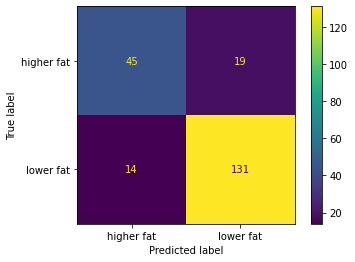

In [24]:
cm_plot = plot_confusion_matrix(svc_search,X_test, y_test)

cm_plot

Below print a classification report on the X_test predictions of svc_search's best model.

In [25]:
print(classification_report(y_test, svc_search.predict(X_test),target_names=["higher fat", "lower fat"]))

              precision    recall  f1-score   support

  higher fat       0.76      0.70      0.73        64
   lower fat       0.87      0.90      0.89       145

    accuracy                           0.84       209
   macro avg       0.82      0.80      0.81       209
weighted avg       0.84      0.84      0.84       209



Since "lower fat" is considered as the **positive class** in this analysis, its precision score is 0.87; the recall score is 0.90; and the f1 score is 0.89. 

Among the total of 145 "lower fat" cheeses in the test dataset, 90% of observations have been correctly identified as "lower fat".

Among the observations that have been predicted as "lower fat", 87% are actally "lower fat" cheeses.

The algorithm has performed fairly well in this case.

## Discussion

Through a complete analysis learned from the UBC Introduction to Machine Learning course, an optimal RBF SVM model has been selected and trained to answer a classification question of whether the given cheese should be identified as a lower fat or higher fat product in the Canadian cheese dataset.

The results show that the RBF SVM model had better performances than the other four estimators in this case, including DummyClassifier, Decision tree, kNN, and Logistic regression. When using it on the test dataset, the accuracy score of the RBF SVM model is 0.842, and the precision, recall, and f1-score are 0.87, 0.90 and 0.89, respectively, considering "lower fat" as the positive class. The algorithm has performed fairly well in its work.

There are some **limitations** or **future improvements** in this analysis that should be highlighted:
1. The results are based on the input features pre-processing, transformations, and model hyperparameters optimizations that have been applied in the report. The analyst (the author) acknowledges that there might be other types of estimators and/or feature engineering methods that have not been included here but may perform a better prediction.

    For example, a preliminary experiment has been carried out by the analyst to drop all three text features from the dataset and proceed with the five models using the default parameters. The result shows this time Decision tree and kNN models performed better than the RBF SVM and Logistic regression. And both of the validation scores from Decision tree and kNN were higher than 0.815. The experiment advised that by simplifying the column processing and transformation process, the prediction performance could be improved. These further discoveries are not included in this assignment but a deep research will be implemented in the future by the analyst. 
2. Since this is the first time the analyst has managed to deal with a dataset mixed with multiple input feature types including numeric, categorical, binary, and particularly text features, a further study is planned to explore better feature pre-processing / transformation and pipeline building methods to efficiently process the text features rather than the current approach that pre-filled missing values particularly for text features first and did not have an imputation transformer inside of the text_transformer pipeline.
3. Dropping irrelevant columns `CheeseId`, `RindTypeEn` could be done prior to splitting the training and test dataset to avoid the repetitive column dropping step for the test set.
4. In the EDA stage, an assumption has been made regarding the weight of the feature of `MoisturePercent` in the prediction. An interpretable model, such as Logistic regression, could be used to have more discussions on this assumption and other features' contributions to the prediction. However, in this report, the Logistic regression result interpretation was not pursued considering the complexity of a large number of transformed columns from text features. This will be analyzed in the future.
5. Due to the limit of current understanding for these algorithms from Scikit-Learn, the analyst recognized that more deep comparisons for different algorithms' predictive performances in this report could be discussed, such as why RBF SVM and Logistic regression had better scores than Decision trees and kNN, and why after dropping the three text columns it seemed to show a reverse conclusion as noted on the above item 1. Motivated by these questions, an in-depth exploration of Scikit-Learn will be conducted after this course.

## References

### Resources Used

Not all the work in this project is original. The following resources have been used as references.

* <font color='blue'>Data Source</font>

The pre-processed Canadian cheese dataset is provided by UBC Introduction to Machine Learning course. And the original data is from the <a href="https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b" target="_blank">Government of Canada's Open Government Portal</a> and follows an <a href="https://open.canada.ca/en/open-government-licence-canada" target="_blank">Open Government Licence (Canada)</a>. 

* <font color='blue'>Report Writing</font>

Markdown formatting for the text cells in JupyterNotebook, *Basic Syntax - The Markdown elements outlined in John Gruber's design document*, retrieved on November 1, 2021 from <a href="https://www.markdownguide.org/basic-syntax/" target="_blank">Markdown Guide</a>.

* <font color='blue'>Python, ML, and Data Vis Knowledges / Skills</font>

Learned from UBC Introduction to Machine Learning, Data Visualization, and Programming in Python for Data Science courses, Piazza group discussions, <a href="https://scikit-learn.org/stable/" target="_blank">Scikit-learn</a>, <a href="https://ubc-cs.github.io/cpsc330/lectures/06_column-transformer-text-feats.html" target="_blank">UBC CPSC 330 Applied Machine Learning course Lecture 6</a> and other self-learning resources from the internet.

<h2><center>**End of the Report**</center></h2>